# What Is My House Worth?
---
by Kevin smith 7/26/2022

## Project Goal
---
The goal of this project is to develop a home price estimation model that performs better than the baseline prediction, and develop recommendations for ways that the model can be improved and deployed. 

This goal will be accomplished utilizing the following steps:

* Planning
* Acqusition
* Prep
* Exploration
* Feature Engineering
* Modeling
* Delivery

### Steps For Reproduction
---
1. You will need an <mark>env.py</mark> file that contains the hostname, username and password of the mySQL database that contains the <mark>telco_churn</mark> database. Store that env file locally in the repository.
2. Clone my repo (including the <mark>acquire.py</mark> , <mark>prepare.py</mark> & <mark>wrangle.py</mark>files.
3. The libraries used are pandas, numpy, scipy, matplotlib, seaborn, and sklearn.
4. You should now be able to run the <mark>zillow_final_report.ipynb</mark> file.

## Planning
---
Their are two essential parts to any good plan. Identify your **Goals**, and the necessary **Steps** to get there. 

### Goals:
1. Identify variables driving housing prices.
2. Develop a model to make value predicitons based on those variable. 
3. Deliver actionable takeaways

### Steps:
1. Initial hypothesis
2. Acquire and cache the dataset
3. Clean, prep, and split the data to prevent data leakage
4. Do some preliminary exploration of the data (including visualiztions and statistical analyses)*
5. Trim dataset of variables that are not statistically significant
6. Determine which machine learning model perfoms the best
7. Utilize the best model on the test dataset
8. Create a final report notebook with streamlined code optimized for a technical audience

*at least 4 visualizations and 2 statistical analyses

## Data Library
---
| **Variable Name** | **Explanation** | **Values** |
| :---: | :---: | :---: |
| bedrooms | The number of bedrooms in the house | Numeric value |
| bathrooms | The number of bathrooms in the house | Numeric value |
| quality | a numeric score based on quality on construction | Numeric value|
| sq_feet | The total area inside the home | Numeric value |
| pool | Whether or not the house has a pool | Yes=1/No=0|
| tax_value| The taxable value of the home in $USD | Numeric |
| yearbuilt | The year in which the home was originally built | Year |
| fips | A unique code specific to the county in which the home is located| Numeric |



In [1]:
import matplotlib.pyplot as plt
from pydataset import data
from datetime import date
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import wrangle
import model
import explore
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import RobustScaler, MinMaxScaler, QuantileTransformer,PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error


## Initial Hypotheses
---
### Square footage drives home value up
- H0: square footage and tax value are independent
- Ha: square footage and tax value are dependent
---
### Age drives home value down
- H0: age and tax value are independent
- Ha: age and tax value are dependent

## Aquisition & Prep
---
The wrangle function will acquire and prepare the data for us. Giving us a nice clean data frame to work with.

In [2]:
# wrangle collects the data from the SQL server, gives us the number of rows collected, 
# accounts for outliers in bedroom, bathroom, and tax value.
# accounts for null values by encoding pool, and by using Sklearn's new iterative imputer for all other nulls
# encodes the fips value as the county that it represents
# converts year built into age by subtracting the year built value from the current year
df = wrangle.wrangle_zillow()

There are 52441 different homes in this data set


In [3]:


print(f'The final number of homes in the data set is {len(df)} meaning we retained {1-((52441-len(df))/52441):.2%} of the data after accounting for outliers')

The final number of homes in the data set is 46875 meaning we retained 89.39% of the data after accounting for outliers


In [4]:
df.head()

,bedrooms,bathrooms,quality,sq_feet,pool,tax_value,fips,age
0,2.0,1.0,6.0,1465.0,0.0,464000.0,ventura,55.0
1,3.0,2.0,6.0,1243.0,1.0,564778.0,orange,60.0
2,4.0,3.0,8.0,2376.0,1.0,145143.0,los_angeles,52.0
3,4.0,3.0,9.0,2962.0,1.0,773303.0,los_angeles,72.0
4,2.0,1.0,5.0,738.0,0.0,218552.0,los_angeles,100.0


### Splitting the data into counties
---
I split the data up by counties to try and account for difference in housing markets. 

In [5]:
la, oc, ven = wrangle.county_split(df)

In [6]:
la.info()
oc.info()
ven.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30515 entries, 2 to 46874
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   30515 non-null  float64
 1   bathrooms  30515 non-null  float64
 2   quality    30515 non-null  float64
 3   sq_feet    30515 non-null  float64
 4   pool       30515 non-null  float64
 5   tax_value  30515 non-null  float64
 6   age        30515 non-null  float64
dtypes: float64(7)
memory usage: 1.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12315 entries, 1 to 46665
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   12315 non-null  float64
 1   bathrooms  12315 non-null  float64
 2   quality    12315 non-null  float64
 3   sq_feet    12315 non-null  float64
 4   pool       12315 non-null  float64
 5   tax_value  12315 non-null  float64
 6   age        12315 non-null  float64
dtypes: float64(7)
memor

### Exploration
---
Answering questions with visuals and statistical analysis.

Question 1. Does square footage drive up house value?

In [7]:
# split data to avoid any leakage

la_train, la_validate, la_test = explore.split(la)
oc_train, oc_validate, oc_test = explore.split(oc)
ven_train, ven_validate, ven_test = explore.split(ven)


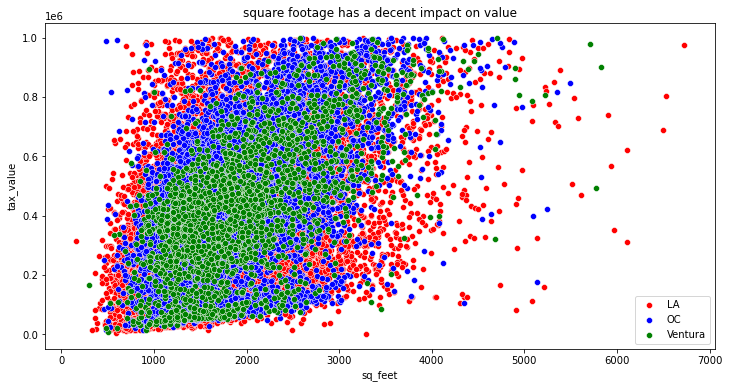

In [8]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=la_train, y='tax_value',x='sq_feet', color='red',label='LA')
sns.scatterplot(data=oc_train, y='tax_value',x='sq_feet',color='blue',label='OC')
sns.scatterplot(data=ven_train, y='tax_value',x='sq_feet',color='green',label='Ventura')
plt.title('square footage has a decent impact on value')
plt.show()

In [9]:
corr, p = stats.pearsonr(la_train.tax_value, la_train.sq_feet)

print(f'There is a {corr :.2%} positive correlation between square footage and tax value in LA. Confidence interval: {1-p}')

There is a 40.56% positive correlation between square footage and tax value in LA. Confidence interval: 1.0


In [10]:
corr, p = stats.pearsonr(oc_train.tax_value, oc_train.sq_feet)

print(f'There is a {corr :.2%} positive correlation between square footage and tax value in Orange County. Confidence interval: {1-p}')

There is a 50.39% positive correlation between square footage and tax value in Orange County. Confidence interval: 1.0


In [11]:
corr, p = stats.pearsonr(ven_train.tax_value, ven_train.sq_feet)

print(f'There is a {corr :.2%} positive correlation between square footage and tax value in Ventura. Confidence interval: {1-p}')

There is a 61.18% positive correlation between square footage and tax value in Ventura. Confidence interval: 1.0


Question 2. Does age drive value down?

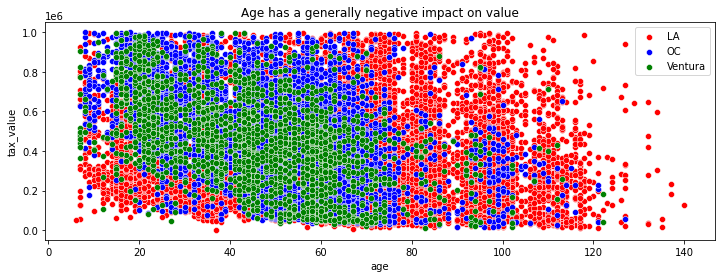

In [12]:
plt.figure(figsize=(12, 4))
sns.scatterplot(data=la_train, y='tax_value',x='age', color='red',label='LA')
sns.scatterplot(data=oc_train, y='tax_value',x='age',color='blue',label='OC')
sns.scatterplot(data=ven_train, y='tax_value',x='age',color='green',label='Ventura')
plt.title('Age has a generally negative impact on value')
plt.legend()
plt.show()

In [13]:
corr, p = stats.pearsonr(la_train.tax_value, la_train.age)
corr, p
print(f'There is a {corr :.2%} correlation between age and tax value in LA. Confidence interval: {1-p}')

There is a -10.96% correlation between age and tax value in LA. Confidence interval: 1.0


In [14]:
corr, p = stats.pearsonr(oc_train.tax_value, oc_train.age)
corr, p
print(f'There is a {corr :.2%} correlation between age and tax value in Orange County. Confidence interval: {1-p}')

There is a -46.12% correlation between age and tax value in Orange County. Confidence interval: 1.0


In [15]:
corr, p = stats.pearsonr(ven_train.tax_value, ven_train.age)
corr, p
print(f'There is a {corr :.2%} correlation between age and tax value in Ventura. Confidence interval: {1-p}')

There is a -48.66% correlation between age and tax value in Ventura. Confidence interval: 1.0


Question 3. Can we combine bedrooms and bathrooms into one column?

0.7628626460426886
0.7028802433647944
Our confidence is 100% that the variables are dependent. We reject the null hypothesis.
0.7127209330954127
0.4562965455392365
Our confidence is 100% that the variables are dependent. We reject the null hypothesis.
0.668311148308664
0.5373332640716312
Our confidence is 100% that the variables are dependent. We reject the null hypothesis.


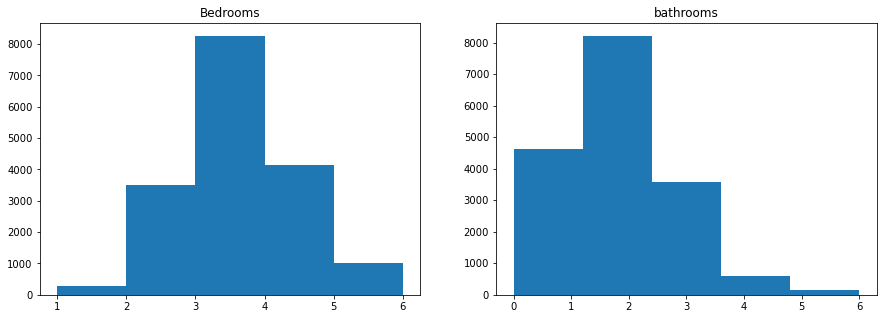

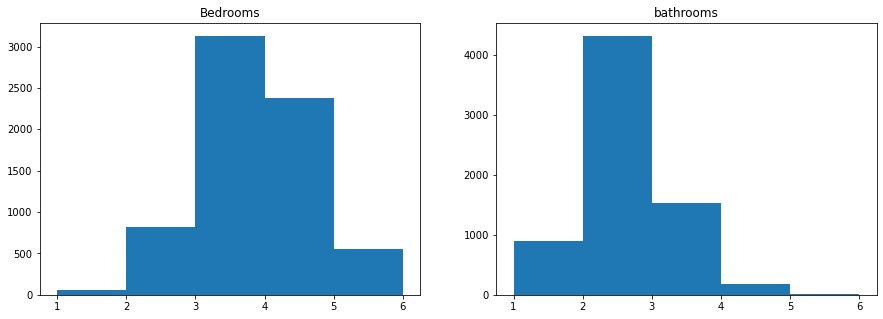

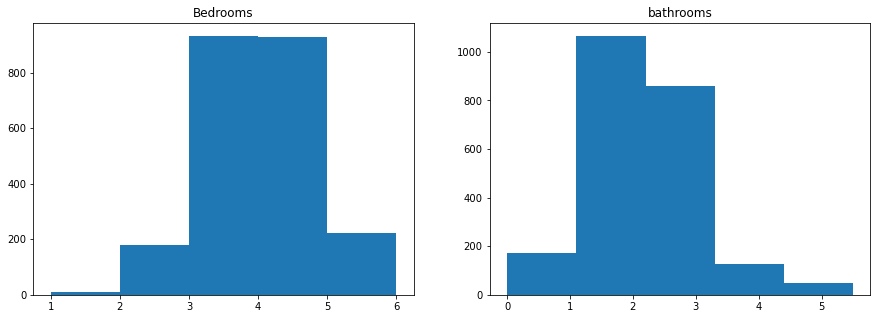

In [16]:
# bed bath test runs a t-test to see if they are dependent and can be combined. if they are, it combines them automatically
explore.bed_bath_test(la_train)
explore.bed_bath_test(oc_train)
explore.bed_bath_test(ven_train)
# they are dependent and the bedrooms and bathrooms columns will be dropped as part of the modeling process

### Feature engineering and modeling
---
After prepping and exploring the data it is time to move on to feature engineering and modeling. i combined these two steps to streamline the current notebook.

 which model performs best for which data set?

The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE using Mean
Train/In-Sample:  224840.49 
Validate/Out-of-Sample:  227253.48 
-----------------
RMSE using Median
Train/In-Sample:  228937.71 
Validate/Out-of-Sample:  231356.52 
-----------------
RMSE for OLS using LinearRegression
Training/In-Sample:  203850.05699596467 
Validation/Out-of-Sample:  207084.5862512328 
model performed 8.12% better than baseline 
-----------------
RMSE for Lasso + Lars
Training/In-Sample:  203850.61977699088 
Validation/Out-of-Sample:  207081.08460660835 
model performed 8.12% better than baseline 
-----------------
RMSE for Polynomial Model, degrees=4
Training/In-Sample:  200780.72309758264 
Validation/Out-of-Sample:  205067.4622819204 
model performed 9.50% better than baseline 
-----------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training:  205889.76445961904 
Validation:  210389.55956235272 
model performed 7.20% better than

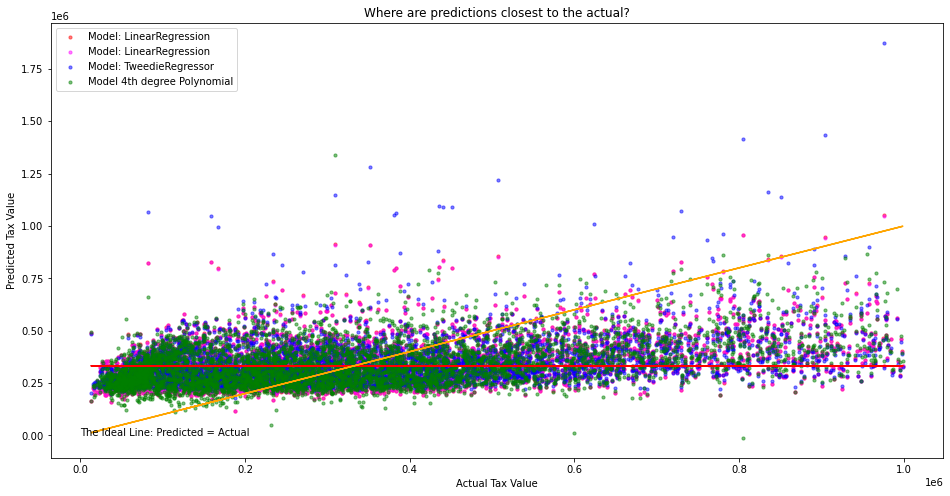

In [17]:
# running all three sets through 4 models each to evaluate performance and choose a model for each.
# each function is utilizing the same random_state during splitting to guarantee consistent results 
# and no data leakage during the process of being split again
model.models(la)

The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE using Mean
Train/In-Sample:  245722.33 
Validate/Out-of-Sample:  249462.51 
-----------------
RMSE using Median
Train/In-Sample:  246188.45 
Validate/Out-of-Sample:  249682.31 
-----------------
RMSE for OLS using LinearRegression
Training/In-Sample:  201807.54773029947 
Validation/Out-of-Sample:  203817.85404717422 
model performed 9.04% better than baseline 
-----------------
RMSE for Lasso + Lars
Training/In-Sample:  201807.72158146414 
Validation/Out-of-Sample:  203821.69841712448 
model performed 9.04% better than baseline 
-----------------
RMSE for Polynomial Model, degrees=4
Training/In-Sample:  194878.07204215028 
Validation/Out-of-Sample:  206369.61703489634 
model performed 12.16% better than baseline 
-----------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training:  200832.9637807814 
Validation:  203285.01782260486 
model performed 9.48% better th

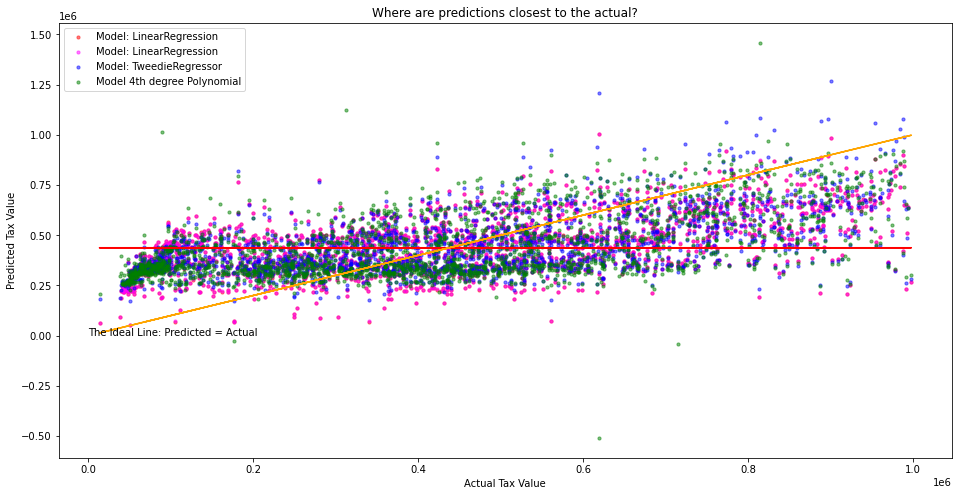

In [18]:
model.models(oc)

The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE using Mean
Train/In-Sample:  223943.22 
Validate/Out-of-Sample:  221217.39 
-----------------
RMSE using Median
Train/In-Sample:  224058.11 
Validate/Out-of-Sample:  221406.93 
-----------------
RMSE for OLS using LinearRegression
Training/In-Sample:  164721.30242489048 
Validation/Out-of-Sample:  172451.7049657066 
model performed 25.75% better than baseline 
-----------------
RMSE for Lasso + Lars
Training/In-Sample:  164721.3817232137 
Validation/Out-of-Sample:  172454.62152091804 
model performed 25.75% better than baseline 
-----------------
RMSE for Polynomial Model, degrees=4
Training/In-Sample:  159605.2807244402 
Validation/Out-of-Sample:  177732.64819334375 
model performed 28.06% better than baseline 
-----------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training:  166910.3367566664 
Validation:  174225.91025729597 
model performed 24.77% better th

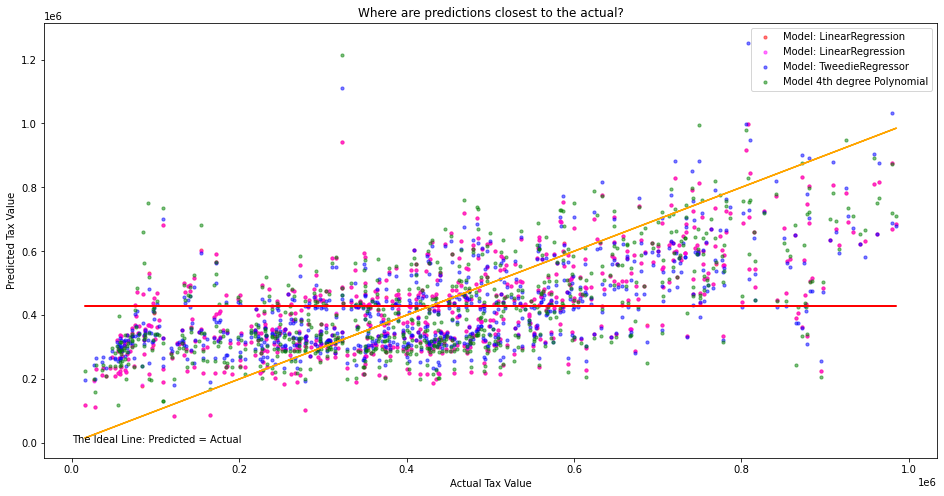

In [19]:
model.models(ven)

In [20]:
model.poly_test(la)
    

The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE for Polynomial Model, degrees=4
Test/Out-of-Sample:  204038.1781870512 
model performed 8.03% better than baseline 
-----------------


In [21]:
model.lasso_test(oc)
model.lasso_test(ven)

The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE for Lasso + Lars
Test/Out-of-Sample:  199810.35784675324 
model performed 9.94% better than baseline 
-----------------
The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE for Lasso + Lars
Test/Out-of-Sample:  174302.17604086577 
model performed 21.43% better than baseline 
-----------------


What happens if we dont split the data by county?

The 5 most useful features for this county are ['quality', 'sq_feet', 'pool', 'age', 'bed_bath'] 
---------------
RMSE using Mean
Train/In-Sample:  234791.82 
Validate/Out-of-Sample:  239140.64 
-----------------
RMSE using Median
Train/In-Sample:  236991.33 
Validate/Out-of-Sample:  241934.92 
-----------------
RMSE for OLS using LinearRegression
Training/In-Sample:  206347.79172628775 
Validation/Out-of-Sample:  210409.3977149379 
model performed 6.99% better than baseline 
-----------------
RMSE for Lasso + Lars
Training/In-Sample:  206348.61166060413 
Validation/Out-of-Sample:  210411.1308044713 
model performed 6.99% better than baseline 
-----------------
RMSE for Polynomial Model, degrees=4
Training/In-Sample:  202613.44401892085 
Validation/Out-of-Sample:  207839.27500325558 
model performed 8.67% better than baseline 
-----------------
RMSE for GLM using Tweedie, power=1 & alpha=0
Training:  207603.7402533672 
Validation:  211741.5761437811 
model performed 6.42% better than b

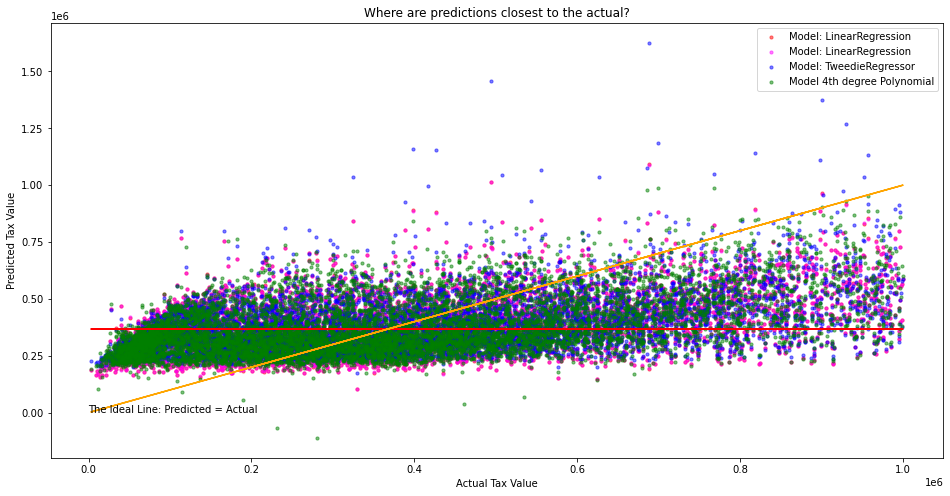

In [22]:
# splitting by county does not necessarily yield better results

model.big_model(df)

### deliverables
---
Here we will complete the goal of the project by delivering actionable suggestions to improve value projections based on our identification of contributing factors. 

Since the model on the dataset as a whole perfomed comparably to the models split by county, I suggest **not** splitting the data unless working with more observations.

my second suggestion is to continue to search for more variables that can drive tax value. Purchase history for individuals houses would be the first place i would look to improve the data, and in turn improve the model.